This notebook is adapted from the official [Stim Getting Started guide](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) by [quantumlib/Stim](https://github.com/quantumlib/Stim). All credit for the original materials goes to the authors.

In [53]:
%pip install stim~=1.14 numpy~=1.0 scipy --quiet   # 1.0 instead of 2.0 for pymatching compatibility later 

Note: you may need to restart the kernel to use updated packages.


In [21]:
import stim
print(stim.__version__)

1.15.0


In [22]:
# Instance of circuit
circuit = stim.Circuit()

# Initialize Bell pair (H-CX)
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Measure of both qubits in Z basis
circuit.append("M", [0, 1])

In [23]:
# display the circuit
circuit

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')

In [24]:
circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

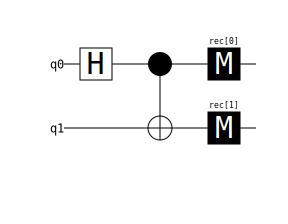

In [25]:
circuit.diagram('timeline-svg')

In [26]:
# 10 measurements from the circuit
sampler = circuit.compile_sampler()
print(sampler.sample(shots = 10))

[[False False]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


|00⟩ + |11⟩ state

In [27]:
# Adding detector annotations to circuit
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)]) 
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


In [28]:
# sample the output with detectors
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots = 5))

[[False]
 [False]
 [False]
 [False]
 [False]]


all false means no detection events

In [29]:
# circuit with noise X_error and tick to track progression of time
circuit = stim.Circuit("""
    H 0
    TICK

    CX 0 1
    X_ERROR(0.2) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

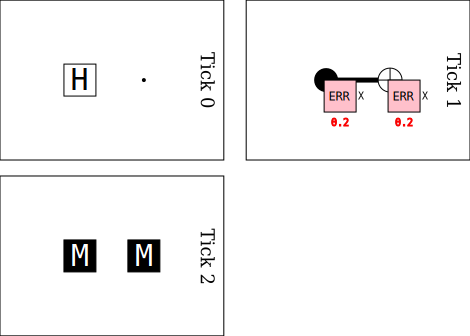

In [30]:
circuit.diagram('timeslice-svg')

In [32]:
# detector outputs after adding noise
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]]


The detection fraction of the circuit is how often detectors fire on average. Given that an X error is being applied to each qubit with 20% probability, and the detector will fire when one of the qubits is hit (but not both), the detection fraction of the detectors in this circuit is 0.8 * 0.2 * 2 = 0.32

Estimation of the detection fraction by just taking a lot of shots, and dividing by the number of shots and the number of detectors

In [33]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)

0.319714


very close to 0.32

before_round_data_depolarization=0.04 and before_measure_flip_probability=0.01. This will insert a DEPOLARIZE1(0.04) operation at the start of each round targeting every data qubit, and an X_ERROR(0.01) just before each measurement operation. This is a "phenomenological noise model"

In [34]:
# error detection circuit
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=25,
    distance=9,
    before_round_data_depolarization=0.4,
    before_measure_flip_probability=0.01)

In [35]:
print(repr(circuit))

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    TICK
    DEPOLARIZE1(0.4) 0 2 4 6 8 10 12 14 16
    CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
    TICK
    X_ERROR(0.01) 1 3 5 7 9 11 13 15
    MR 1 3 5 7 9 11 13 15
    DETECTOR(1, 0) rec[-8]
    DETECTOR(3, 0) rec[-7]
    DETECTOR(5, 0) rec[-6]
    DETECTOR(7, 0) rec[-5]
    DETECTOR(9, 0) rec[-4]
    DETECTOR(11, 0) rec[-3]
    DETECTOR(13, 0) rec[-2]
    DETECTOR(15, 0) rec[-1]
    REPEAT 24 {
        TICK
        DEPOLARIZE1(0.4) 0 2 4 6 8 10 12 14 16
        CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
        TICK
        CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
        TICK
        X_ERROR(0.01) 1 3 5 7 9 11 13 15
        MR 1 3 5 7 9 11 13 15
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-8] rec[-16]
        DETECTOR(3, 0) rec[-7] rec[-15]
        DETECTOR(5, 0) rec[-6] rec[-14]
        DETECTOR(7, 0) rec[-5] rec[-13]
        DETECTOR(9, 0) rec[-4] rec

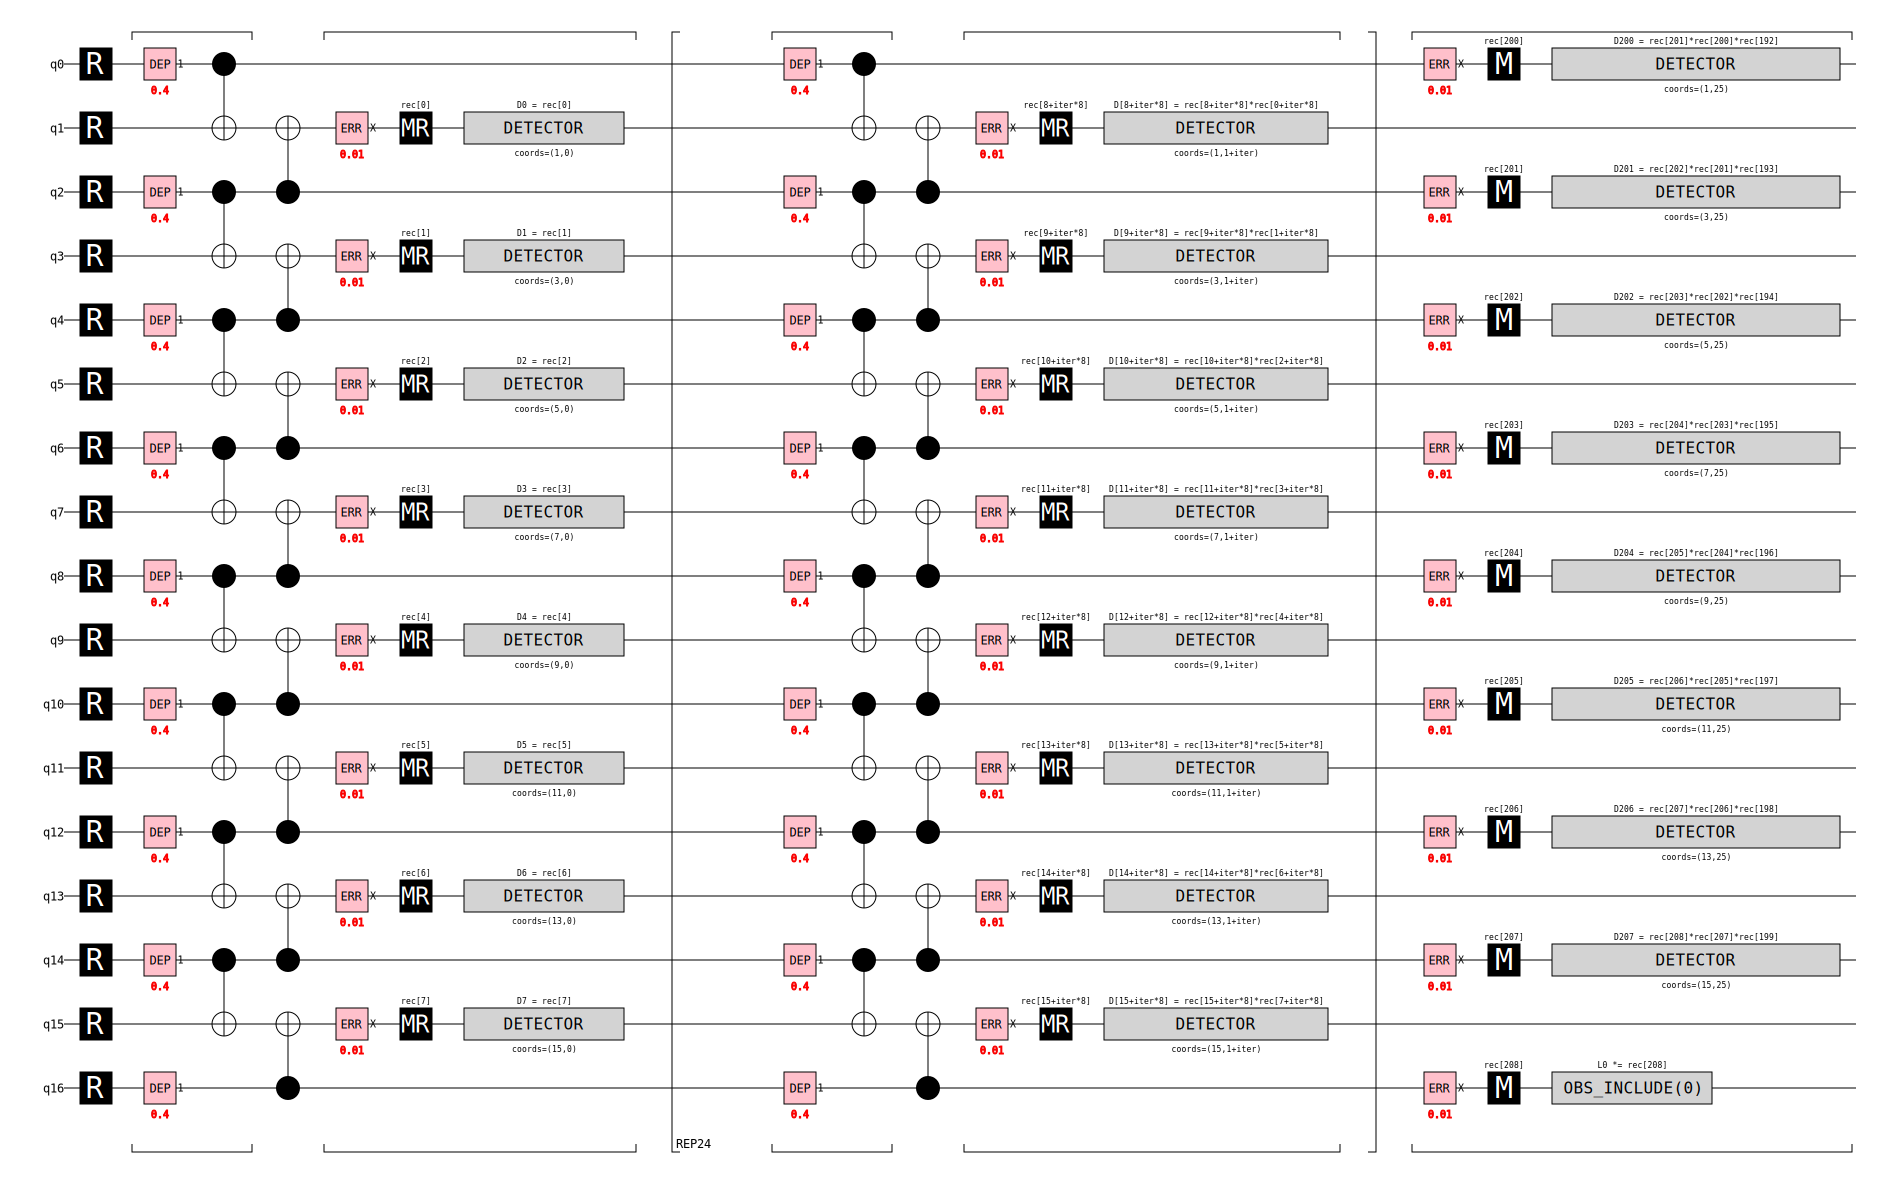

In [36]:
circuit.diagram('timeline-svg')

Sampling the measurements from circuit and printing out the results split up just right so that time advances from line to line:

In [37]:
sampler = circuit.compile_sampler()
one_sample = sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 8):
    timeslice = one_sample[k:k+8]
    print("".join("1" if e else "_" for e in timeslice))

_1111111
1__1_1_1
_1______
11__11__
_1__1_1_
11__11_1
1_1_____
__1_11_1
1_11_11_
11____11
_1_11_1_
1_____1_
1____1__
111__1_1
_____11_
_______1
___11___
1_11__11
1_11__11
1_1__111
1___11__
___1_11_
______11
11____11
1111_1__
1_1_11__
_


In [38]:
# Now sampling the detectors, expect sparser data

detector_sampler = circuit.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 8):
    timeslice = one_sample[k:k+8]
    print("".join("!" if e else "_" for e in timeslice))

_!!__!_!
!!_!_!__
_____!__
!!__!_!_
___!_!!_
_!___!!_
__!!!_!!
_!_!_!__
!!_!!__!
____!!__
!_!!!!__
!!_!_!__
_!!!_!__
_!_____!
_!_!____
___!_!__
_!_____!
__!!__!!
_______!
!!_!!_!!
___!!__!
__!_!__!
!__!!__!
!____!_!
_!______
________


In Stim's detector output, !s indicate errors and usually appear in pairs. Each ! must pair with another ! or with a boundary. The logical observable is the leftmost data qubit, which flips once for each ! paired with the left boundary. If it's flipped an even number of times, the observable is correct; if odd, it needs to be flipped. A syndrome decoder solves this matching problem to determine if the logical qubit was flipped.

In [39]:
# Error detector model

dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.266667) D0
    error(0.266667) D0 D1
    error(0.01) D0 D8
    error(0.266667) D1 D2
    error(0.01) D1 D9
    error(0.266667) D2 D3
    error(0.01) D2 D10
    error(0.266667) D3 D4
    error(0.01) D3 D11
    error(0.266667) D4 D5
    error(0.01) D4 D12
    error(0.266667) D5 D6
    error(0.01) D5 D13
    error(0.266667) D6 D7
    error(0.01) D6 D14
    error(0.01) D7 D15
    error(0.266667) D7 L0
    detector(1, 0) D0
    detector(3, 0) D1
    detector(5, 0) D2
    detector(7, 0) D3
    detector(9, 0) D4
    detector(11, 0) D5
    detector(13, 0) D6
    detector(15, 0) D7
    repeat 23 {
        error(0.266667) D8
        error(0.266667) D8 D9
        error(0.01) D8 D16
        error(0.266667) D9 D10
        error(0.01) D9 D17
        error(0.266667) D10 D11
        error(0.01) D10 D18
        error(0.266667) D11 D12
        error(0.01) D11 D19
        error(0.266667) D12 D13
        error(0.01) D12 D20
        error(0.266667) D13 D14
        er

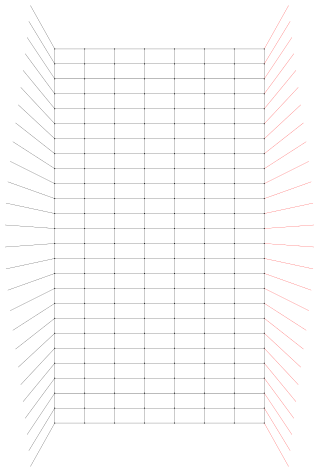

In [40]:
# error detector model as graph 
dem.diagram("matchgraph-svg")

In the diagram above, each node represents a detector and each edge corresponds to an error mechanism. The decoder, using PyMatching, identifies likely errors by connecting pairs of excited detectors (nodes that detect anomalies) or matching them to boundaries, minimizing the total weight (number or severity of errors). 

Stim simplifies this process by converting a quantum circuit into a `DetectorErrorModel`—a graph-like structure that lists all possible errors, the detectors they trigger, and any logical observable flips. This format is much easier for decoders to work with than raw circuits, and tools like PyMatching can be directly used without needing to manually construct the graph. 


In [51]:
%pip install pymatching~=2.0 --quiet

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pymatching

In [43]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [44]:
circuit = stim.Circuit.generated("repetition_code:memory", rounds=100, distance=9, before_round_data_depolarization=0.03)
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 5 wrong predictions (logical errors) out of 100000 shots


In [46]:
# errors with 13% noise
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=100,
    distance=9,
    before_round_data_depolarization=0.13,
    before_measure_flip_probability=0.01)
num_shots = 10_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 1219 wrong predictions (logical errors) out of 10000 shots


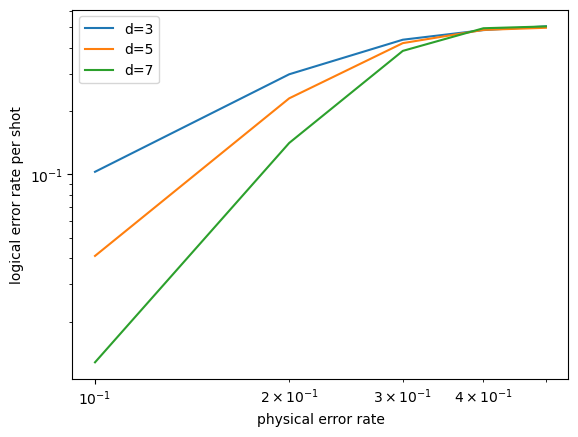

In [47]:
# estimate of threshold of repetion code using monte carlo

import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

In [49]:
%pip install sinter~=1.14 --quiet

Note: you may need to restart the kernel to use updated packages.


In [50]:
import sinter
from typing import List

In [54]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

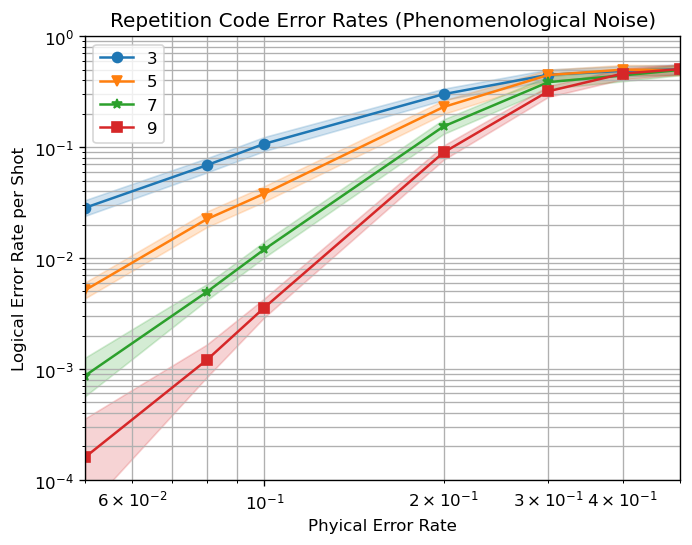

In [55]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [ ]:
# estimating threshold of surface code

surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)